Financiera Compartamos
-----------------------------------------

## Limpieza de Datos

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")
# import data
import numpy as np
import pandas as pd
df = pd.read_excel('data/dataOriginal.xlsx')
# cast to str
df.codigoCuenta=df.codigoCuenta.apply(str)
df.codigoCliente=df.codigoCliente.apply(str)
df.codigoFuente=df.codigoFuente.apply(str)
# cast to date
df.fechaApertura = pd.to_datetime(df.fechaApertura)
df.fechaVigencia = pd.to_datetime(df.fechaVigencia)
df.fechaUltimoPago = pd.to_datetime(df.fechaUltimoPago)
df.fechaVencimiento = pd.to_datetime(df.fechaVencimiento)
df.dSalPag = pd.to_datetime(df.dSalPag)
# drop useless columns
df.drop(['codigoFuente', 'ctipcuo', 'fechaVigencia', 'fechaTermino', 'cestado', 
         'ccodprd', 'ccodana', 'cCodPdc', 'capitalDesembolsado', 'diasDeAtraso',
         'Fuente de financiamiento', 'nPerLbr', 'cComApr', 'diasAtrasoMaximo',
         'cctapre', 'ntasint', 'npagcta', 'nmorpag', 'ngastos', 'ngaspag',
         'nintpen', 'nintcal', 'nintpag', 'nintmor', 'capitalCalculado'
        ], axis=1, inplace=True)

### Datos Cualitativos

In [2]:
df.describe(include=['object'])

,codigoCuenta,codigoCliente,tipoCredito,sectorEconomico,ctipcal,condicionCredito,cmarjud
count,30575,30575,30575,30575,30575,30575,30575
unique,30575,26412,3,8,2,2,3
top,22310153584,24082661,R,01,S,Z,S
freq,1,4,18526,14892,30471,30433,27708


_Establecer como index a codigo cuenta y cambiar codigo cliente a valor si es unica cuenta_

In [3]:
dftest = df['codigoCuenta'].groupby([df['codigoCliente']]).count()
md1c = dftest.index[dftest==1]
df['cuentaUnica']=df.codigoCliente.isin(md1c)
df.cuentaUnica=df.cuentaUnica.apply(int).apply(str)
df.drop(['codigoCliente'], axis=1, inplace=True)
df = df.set_index('codigoCuenta')

_Verificar Datos de tipo objeto_

In [4]:
df.describe(include=['object'])

,tipoCredito,sectorEconomico,ctipcal,condicionCredito,cmarjud,cuentaUnica
count,30575,30575,30575,30575,30575,30575
unique,3,8,2,2,3,2
top,R,01,S,Z,S,1
freq,18526,14892,30471,30433,27708,22671


In [5]:
display('Tipo Credito', df.tipoCredito.unique())
display('Sector Económico', df.sectorEconomico.unique())#(01,02,03) (04,05) (06,07)
display('Tipo de Cálculo', df.ctipcal.unique())
display('Condición Crédito', df.condicionCredito.unique())
display('Mar Judicial', df.cmarjud.unique())

'Tipo Credito'

array(['N', 'R', 'U'], dtype=object)

'Sector Económico'

array(['01', '03', '02', '05', '07', '04', '  ', '06'], dtype=object)

'Tipo de Cálculo'

array(['S', 'E'], dtype=object)

'Condición Crédito'

array(['Z', 'J'], dtype=object)

'Mar Judicial'

array(['S', 'J', 'P'], dtype=object)

__Buscando Campos en blanco__

In [6]:
df.sectorEconomico[df.sectorEconomico=='  ']=None
df.isnull().sum() # buscar campos sin datos

tipoCredito             0
Moneda                  0
modalidadCredito        0
sectorEconomico       438
destinoCredito          0
fechaApertura           0
ctipper                 0
ctipcal                 0
fechaUltimoPago      1361
montoApertura           0
capitalPagado           0
numeroDeCuotas          0
condicionCredito        0
cmarjud                 0
dSalPag             23968
fechaVencimiento        9
nTasEfe                 0
cCodOfi                 0
nPerGra                 0
cuentaUnica             0
dtype: int64

__Definimos a los que son deudores__

In [7]:
df['esDeudor'] = np.int32(df.dSalPag.isnull())#1:deudor, 0:no deudor
df.drop(['dSalPag'], axis=1, inplace=True)

### Datos de Tiempo

In [8]:
df.describe(include=['datetime'])

,fechaApertura,fechaUltimoPago,fechaVencimiento
count,30575,29214,30566
unique,907,2037,1331
top,2012-08-31 00:00:00,2013-05-28 00:00:00,2013-12-02 00:00:00
freq,899,1049,326
first,2009-12-22 00:00:00,2010-02-10 00:00:00,2010-04-17 00:00:00
last,2012-12-31 00:00:00,2018-08-31 00:00:00,2018-01-08 00:00:00


### Filtro de data por Fechas

In [9]:
df.dropna(subset=['fechaVencimiento'], inplace=True) # quitamos data sin fecha de vencimiento
diasxmes = 30
df['diasSinPagar'] = np.int32(((df.fechaVencimiento - df.fechaUltimoPago).dt.days).fillna((df.fechaVencimiento - df.fechaApertura).dt.days))
df['clienteMoroso'] = (df.diasSinPagar<0).apply(int).apply(str) # ultimo pago post fecha vencida
df['diasSinPagar'] = np.abs(df.diasSinPagar)
df.clienteMoroso.describe()

count     30566
unique        2
top           0
freq      25219
Name: clienteMoroso, dtype: object

__Retirando data no útil__

In [10]:
# quitamos data que pueda alterar nuestra predictividad
df.dropna(subset=['sectorEconomico'], inplace=True) # quitamos data sin sector economico definido
df.drop(['fechaApertura'], axis=1, inplace=True)
df.drop(['fechaUltimoPago'], axis=1, inplace=True)
df.drop(['fechaVencimiento'], axis=1, inplace=True)
df.isnull().sum() # buscar campos sin datos

tipoCredito         0
Moneda              0
modalidadCredito    0
sectorEconomico     0
destinoCredito      0
ctipper             0
ctipcal             0
montoApertura       0
capitalPagado       0
numeroDeCuotas      0
condicionCredito    0
cmarjud             0
nTasEfe             0
cCodOfi             0
nPerGra             0
cuentaUnica         0
esDeudor            0
diasSinPagar        0
clienteMoroso       0
dtype: int64

### Datos Cuantitativos

In [11]:
df.describe(include=['int64'])

,Moneda,modalidadCredito,destinoCredito,ctipper,numeroDeCuotas,cCodOfi,nPerGra
count,30128.000000,30128.000000,30128.000000,30128.000000,30128.000000,30128.000000,30128.000000
mean,1.001129,1.021044,3.217738,1.996448,13.244855,15.277549,0.000133
std,0.033575,0.238289,2.132137,0.059490,5.651643,9.512876,0.014112
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000,2.000000,12.000000,8.000000,0.000000
50%,1.000000,1.000000,2.000000,2.000000,12.000000,14.000000,0.000000
75%,1.000000,1.000000,4.000000,2.000000,12.000000,24.000000,0.000000
max,2.000000,5.000000,8.000000,2.000000,60.000000,59.000000,2.000000


__Analizando los Campos__

In [12]:
display('Moneda', df.Moneda.unique())
display('Modalidad Crédito', df.modalidadCredito.unique())
display('Destino Crédito', df.destinoCredito.unique())
display('Tipo Persona', df.ctipper.unique())
display('Numero de Cuotas', df.numeroDeCuotas.unique()) # numerico, cuotas (meses)
display('Oficinas', df.cCodOfi.unique()) # agrupar por pais, zona
display('Periodo de Gracia', df.nPerGra.unique()) # numerico, periodos de gracia (meses)

'Moneda'

array([1, 2])

'Modalidad Crédito'

array([1, 3, 5])

'Destino Crédito'

array([2, 4, 7, 8, 1, 3, 6, 5])

'Tipo Persona'

array([2, 1])

'Numero de Cuotas'

array([12, 18, 24,  9,  6, 36, 30, 15,  1, 14, 10,  8, 16, 13, 20, 60, 48,
        7, 25, 22, 34, 21, 17,  4,  3, 40, 27, 19, 28, 42, 44, 33,  5, 11,
       32, 38, 29, 26, 35,  2])

'Oficinas'

array([ 1, 24,  7, 14, 26,  2, 22, 29,  5,  3, 27, 30,  4, 36,  6, 28, 25,
        8, 37, 57,  9, 11, 31, 59, 13, 32, 10, 12, 15, 38, 16, 17, 35, 18,
       19, 20, 33, 34])

'Periodo de Gracia'

array([0, 2, 1])

__Definimos los que si serán numericos enteros__

In [17]:
df.Moneda=df.Moneda.apply(str)
df.modalidadCredito=df.modalidadCredito.apply(str)
df.destinoCredito=df.destinoCredito.apply(str)
df.ctipper=df.ctipper.apply(str)
df.cCodOfi=df.cCodOfi.apply(str)
df.describe(include=['int64'])

,numeroDeCuotas,nPerGra
count,30128.000000,30128.000000
mean,13.244855,0.000133
std,5.651643,0.014112
min,1.000000,0.000000
25%,12.000000,0.000000
50%,12.000000,0.000000
75%,12.000000,0.000000
max,60.000000,2.000000


__Datos Cuantitativos no exactos, numéricos de punto flotante (Reales)__

In [18]:
df.describe(include=['float'])

,montoApertura,capitalPagado,nTasEfe
count,30128.000000,30128.000000,30128.000000
mean,4085.468884,1978.120835,3.670227
std,5718.899807,3500.031275,0.670471
min,138.490000,0.000000,1.090000
25%,1000.000000,364.037500,3.290000
50%,2000.000000,858.385000,3.490000
75%,5000.000000,1981.987500,3.990000
max,60000.000000,59840.580000,6.993000


In [19]:
montoMensual = (df.montoApertura/df.numeroDeCuotas)
df['numeroCuotasPagadas']=(df.capitalPagado/montoMensual).apply(int)
df.describe(include=['int64'])

,numeroDeCuotas,nPerGra,numeroCuotasPagadas
count,30128.000000,30128.000000,30128.000000
mean,13.244855,0.000133,5.610462
std,5.651643,0.014112,4.833444
min,1.000000,0.000000,0.000000
25%,12.000000,0.000000,2.000000
50%,12.000000,0.000000,5.000000
75%,12.000000,0.000000,8.000000
max,60.000000,2.000000,59.000000


# Graficos de Visualización

In [42]:
#df.describe(include=['object'])
#dftest = df['codigoCuenta'].groupby([df['codigoCliente']]).count()
#df['unicaCuenta']=df.codigoCliente.isin(dftest.index[dftest=1]).apply('str')
#df.drop(['codigoCuenta'], axis=1, inplace=True)
#df.codigoCliente=df.codigoCliente.apply(str)
#display(df.describe(include=['object']))
"""
int 
    numeroDeCuotas 	nPerGra 	numeroCuotasPagadas
float
    montoApertura 	capitalPagado 	nTasEfe
object
    tipoCredito 	Moneda 	modalidadCredito 	sectorEconomico 	
    destinoCredito 	ctipper 	ctipcal 	condicionCredito 	
    cmarjud 	cCodOfi 	cuentaUnica 	clienteMoroso
"""
dfTrain = df.copy()
dfTrain['tipoCreditoN']=(dfTrain.tipoCredito=='N').astype(int)
dfTrain['tipoCreditoR']=(dfTrain.tipoCredito=='N').astype(int)
dfTrain['monedaSol']=(dfTrain.Moneda=='1').astype(int)
dfTrain['modCredito']=(dfTrain.modalidadCredito=='1').astype(int)
dfTrain['modOrdinario']=(dfTrain.modalidadCredito=='3').astype(int)
dfTrain['seBajo']=(dfTrain.sectorEconomico.isin('01','02','03')).astype(int)
dfTrain['seMedio']=(dfTrain.sectorEconomico.isin('04','05')).astype(int)



In [43]:
dfGraphics = df.copy()
display(dfGraphics.tipoCredito.unique())
display(dfGraphics.Moneda.unique())
display(dfGraphics.modalidadCredito.unique())
display(dfGraphics.sectorEconomico.unique())
display(dfGraphics.destinoCredito.unique())
display(dfGraphics.ctipper.unique())
display(dfGraphics.ctipcal.unique())
display(dfGraphics.condicionCredito.unique())
display(dfGraphics.cmarjud.unique())
display(dfGraphics.cCodOfi.unique())
display(dfGraphics.cuentaUnica.unique())
display(dfGraphics.clienteMoroso.unique())

array(['N', 'R', 'U'], dtype=object)

array(['1', '2'], dtype=object)

array(['1', '3', '5'], dtype=object)

array(['01', '03', '02', '05', '07', '04', '06'], dtype=object)

array(['2', '4', '7', '8', '1', '3', '6', '5'], dtype=object)

array(['2', '1'], dtype=object)

array(['S', 'E'], dtype=object)

array(['Z', 'J'], dtype=object)

array(['S', 'J', 'P'], dtype=object)

array(['1', '24', '7', '14', '26', '2', '22', '29', '5', '3', '27', '30',
       '4', '36', '6', '28', '25', '8', '37', '57', '9', '11', '31', '59',
       '13', '32', '10', '12', '15', '38', '16', '17', '35', '18', '19',
       '20', '33', '34'], dtype=object)

array(['1', '0'], dtype=object)

array(['0', '1'], dtype=object)

In [49]:
#dfGraphics.tipoCredito.replace(['N', 'R', 'U'], ['Nuevo', 'Recurrente', 'Recuperado'], inplace=True)


codigoCuenta
10110679551     1
10110679817     0
10110683785     0
10110685848     0
10110687380     0
10110689311     0
10110690798     0
10110691150     0
10110691416     0
10110692976     0
10110693685     0
10110694105     0
10110695813     1
10110696225     0
10110696928     0
10110697025     0
10110697215     0
10110697280     1
10110697330     0
10110698023     1
10110699039     1
10110699161     1
10110699914     1
10110700456     0
10110701348     0
10110702387     0
10110702395     0
10110702783     0
10110703062     0
10110703674     0
               ..
152310003834    0
152310003990    0
152310004246    0
152310004642    1
152310004683    0
162310174493    1
292310056497    1
292310056711    1
172310125288    1
172310125346    1
172310125734    1
252310217663    1
252310217820    1
252310217853    0
252310217978    0
252310218034    0
222110040326    1
262410002444    0
262410002634    0
262410004119    0
242310029978    1
242310030208    0
242310030323    0
242310030588   

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib notebook

g = sns.catplot(x="Moneda", y="montoApertura",
                 hue="tipoCredito", col="esDeudor",
                 data=df, kind="bar",
                 height=4, aspect=.7)
plt.show()


AttributeError: module 'seaborn' has no attribute 'catplot'

In [34]:
g = sns.catplot(x="Moneda", y="numeroDeCuotas",
                 hue="tipoCredito", col="esDeudor",
                 data=df, kind="bar",
                 height=4, aspect=.7)
plt.show()

AttributeError: module 'seaborn' has no attribute 'catplot'

<IPython.core.display.Javascript object>


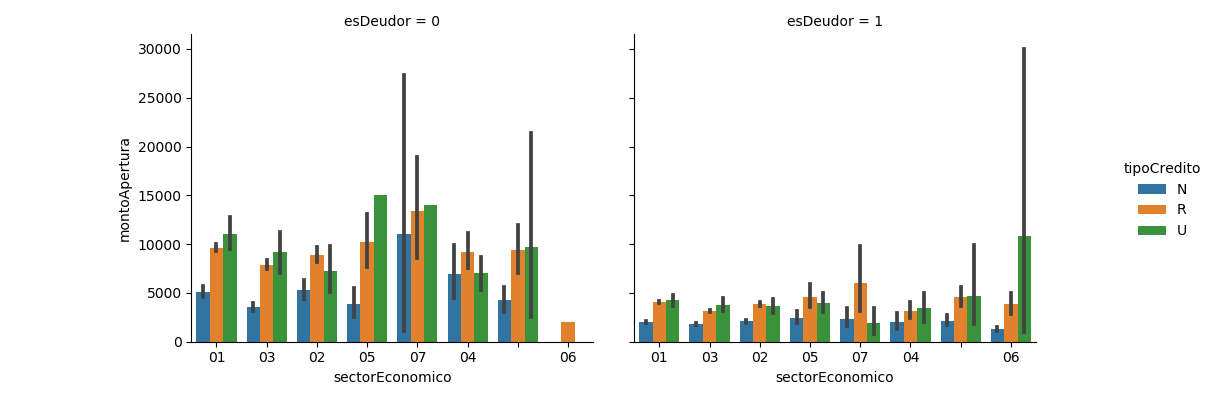

In [40]:
g = sns.catplot(x="sectorEconomico", y="montoApertura",
                 hue="tipoCredito", col="esDeudor",
                 data=df, kind="bar",
                 height=4, aspect=.7)
plt.show()

In [32]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(df, hue="esDeudor", col="esDeudor", height=4)
g.map(hexbin, "montoApertura", "numeroDeCuotas");#, extent=[0, 50, 0, 10]
plt.show()

TypeError: __init__() got an unexpected keyword argument 'height'

<IPython.core.display.Javascript object>


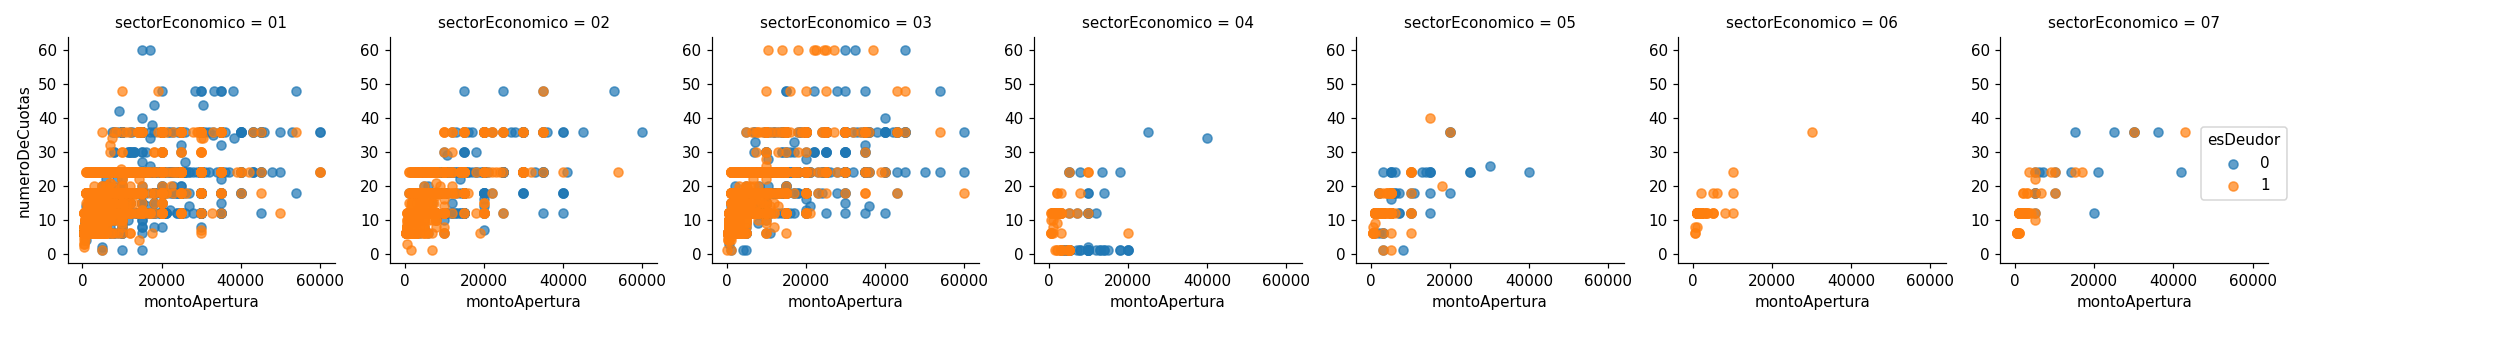

In [33]:
g = sns.FacetGrid(df, col="sectorEconomico", hue="esDeudor")
g.map(plt.scatter, "montoApertura", "numeroDeCuotas", alpha=.7)
g.add_legend();

<IPython.core.display.Javascript object>


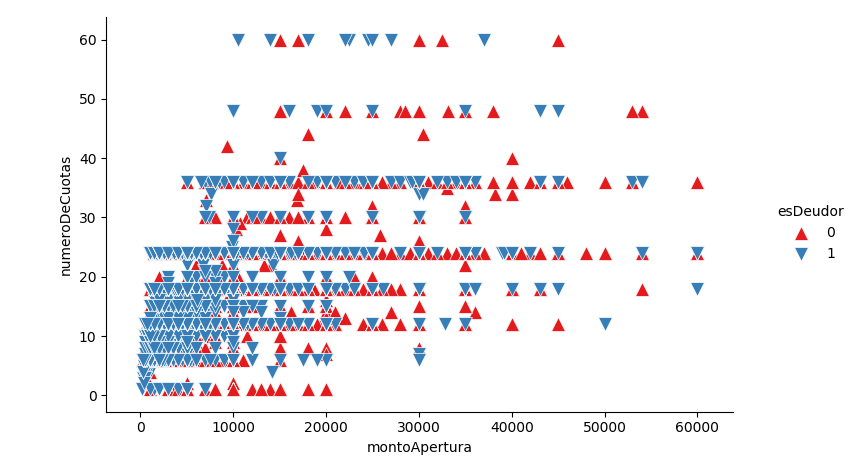

In [33]:
g = sns.FacetGrid(df, hue="esDeudor", palette="Set1", height=5, hue_kws={"marker": ["^", "v"]})
g.map(plt.scatter, "montoApertura", "numeroDeCuotas", s=100, linewidth=.5, edgecolor="white")
g.add_legend();
plt.show()

In [ ]:

#un cliente puede tener varias cuentas, pero con diferentes tipos de asociaciones
#dftest = df['codigoCuenta'].groupby([df['codigoCliente']]).count() #, df['company']
#dftest2 = df[['codigoCuenta', 'codigoCliente']]
#pd.merge(dftest2, dftest, how='left',  left_on=['codigoCliente'])
#dftest..count(['codigoCliente'])  #[dftest>1]
#seaborn.barplot()

#https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_groups/
#https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
#https://pandas.pydata.org/pandas-docs/stable/merging.html
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html
#https://articulo.mercadolibre.com.pe/MPE-430677380-oferta-ultimo-stock-iphone-7-plus-128gb-4g-nuevo-libre-_JM
#https://seaborn.pydata.org/generated/seaborn.barplot.html
#https://pandas.pydata.org/pandas-docs/stable/comparison_with_sql.html#compare-with-sql-join